In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy import stats

/home/marko/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
start_date = '1994-01-01'
end_date = '2014-06-01'

cols, parse_dates = ['permno', 'ret', 'date'], ['date']
dtypes = {
    'permno': np.uint32,
    'ret': np.float32
}

raw_data = pd.read_csv('data/characteristics_data_feb2017.csv', usecols=cols, dtype=dtypes, parse_dates=parse_dates)
raw_data = raw_data.pivot(index='date', columns='permno', values='ret')
raw_data = raw_data[start_date:end_date].dropna(axis='columns')
r = np.log(raw_data + 1)

# Equal Weight Market Portfolio
EWM = raw_data.sum(axis=1) / len(raw_data)
ewm = np.log(1 + EWM)

spy = yf.download(['SPY'], start=start_date, end=end_date, interval='1d', back_adjust=True, progress=False)['Close', 'SPY']
rm = np.log(spy.resample('ME').last()) - np.log(spy.resample('ME').first())

YF.download() has changed argument auto_adjust default to True


In [3]:
# Single factor market model
res = [stats.linregress(rm, r[i]) for i in r]
alpha = [res_i.intercept for res_i in res]
beta = [res_i.slope for res_i in res]

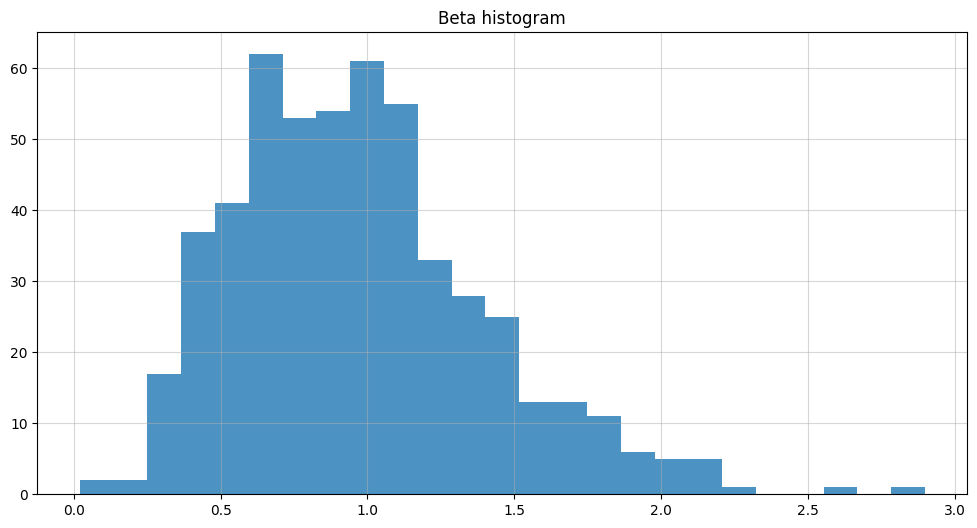

In [4]:
plt.figure(figsize=(12,6))
plt.hist(beta, bins=25, alpha=0.8)
plt.title('Beta histogram')
plt.grid(alpha=0.5)
plt.show()

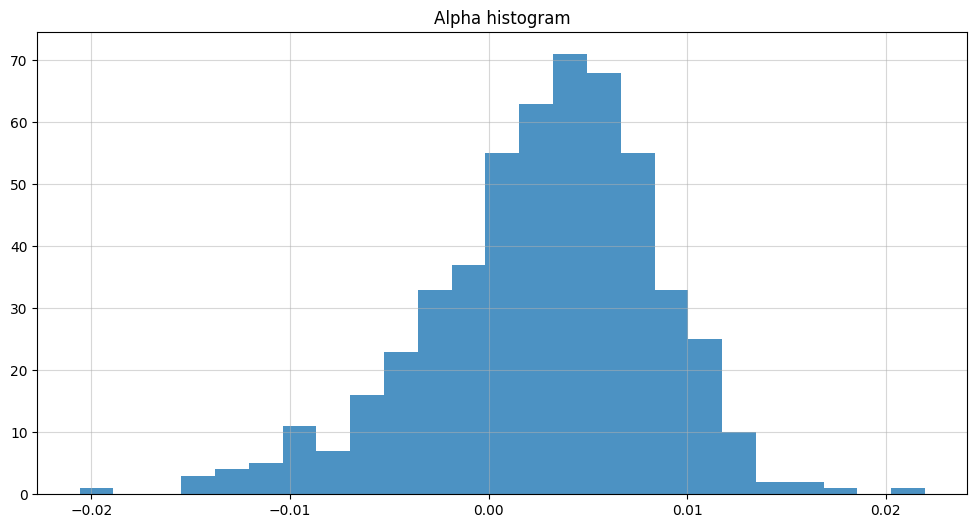

In [5]:
plt.figure(figsize=(12,6))
plt.hist(alpha, bins=25, alpha=0.8)
plt.title('Alpha histogram')
plt.grid(alpha=0.5)
plt.show()

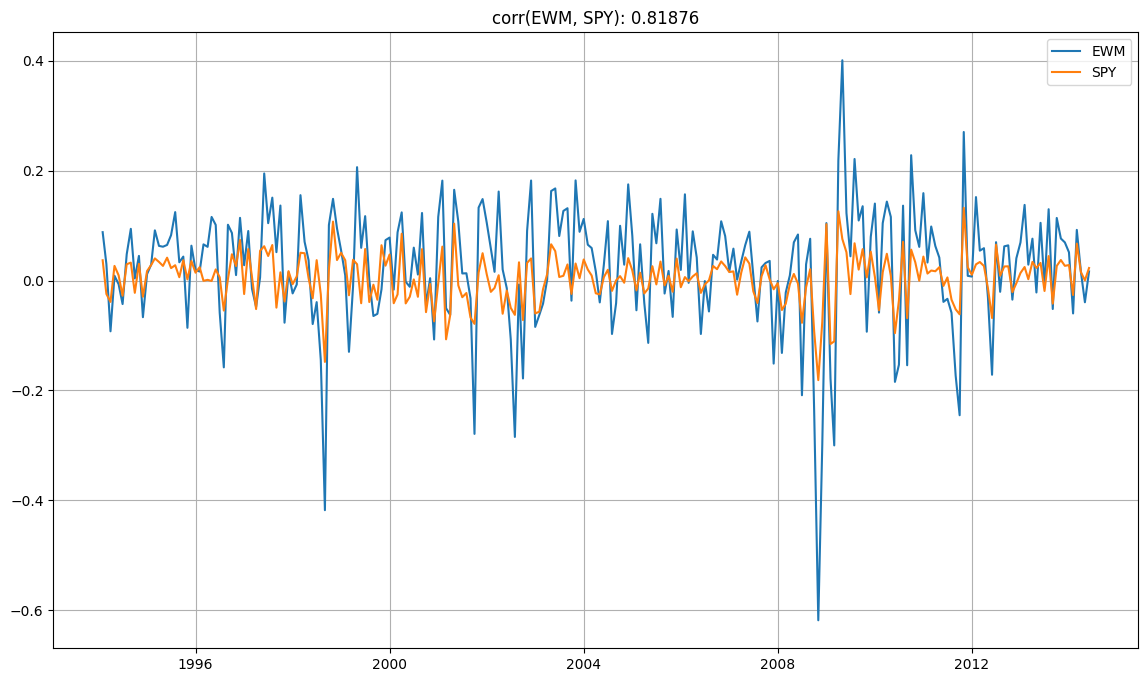

In [15]:
plt.figure(figsize=(14,8))
plt.plot(ewm, label='EWM')
plt.plot(rm, label='SPY')
plt.title(f'corr(EWM, SPY): {np.corrcoef(ewm, rm)[0, 1]:.5f}')
plt.legend()
plt.grid()
plt.show()

print()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

class SimpleVAE_v2(pl.LightningModule):
    def __init__(self, input_dim=526, latent_dim=1, hidden_dim=128, dropout=0.25, lr=1e-4, weight_decay=1e-6):
        super().__init__()
        self.save_hyperparameters()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Linear(latent_dim, input_dim)
        
        self.lr = lr
        self.weight_decay = weight_decay
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        log_var = self.fc_var(hidden)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    def loss_function(self, recon_x, x, mu, log_var):
        # Reconstruction loss (MSE for continuous financial data)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        
        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss
        loss = recon_loss + kl_loss
        
        return loss, recon_loss, kl_loss
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        recon_x, mu, log_var = self(x)
        loss, recon_loss, kl_loss = self.loss_function(recon_x, x, mu, log_var)
        
        # Log metrics
        self.log('train_loss', loss)
        self.log('train_recon_loss', recon_loss)
        self.log('train_kl_loss', kl_loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch[0]
        recon_x, mu, log_var = self(x)
        loss, recon_loss, kl_loss = self.loss_function(recon_x, x, mu, log_var)
        
        # Log metrics
        self.log('val_loss', loss)
        self.log('val_recon_loss', recon_loss)
        self.log('val_kl_loss', kl_loss)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [19]:
# Data preparation function
def prepare_data(data, train_ratio=0.8, batch_size=1, num_workers=8):
    """
    Prepare dataframe
    """
    # Convert to numpy array
    returns_data = data.values
    
    # Shape: (245, 526) - each row is a time step with returns for all stocks
    
    # Split into train and validation
    train_size = int(train_ratio * returns_data.shape[0])
    train_data = returns_data[:train_size]
    val_data = returns_data[train_size:]
    
    # Convert to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    
    # Create DataLoaders
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers
    )
    
    return train_loader, val_loader


# Main training function
def train_financial_vae(train_loader, val_loader, total_epochs=3, input_dim=526, hidden_dim=128):
    # Set up model
    model = SimpleVAE_v2(
        input_dim=input_dim,
        latent_dim=1,
        hidden_dim=hidden_dim,
        dropout=0.25,
        lr=1e-4,
        weight_decay=1e-6
    )
    
    # Set up trainer with epochs instead of steps
    trainer = pl.Trainer(
        max_epochs=total_epochs,
        val_check_interval= 1.0 / total_epochs,
        log_every_n_steps=50,
        enable_progress_bar=True
    )
    
    # Train the model
    trainer.fit(model, train_loader, val_loader)
    
    return model

In [51]:
def get_latent_values(model, dataloader):
    """
    Generate latent values
    """
    model.eval()
    mu_values = []
    latent_values = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0]
            mu, log_var = model.encode(x)
            z = model.reparameterize(mu, log_var)
            mu_values.append(mu.cpu().numpy())
            latent_values.append(z.cpu().numpy())

    mu_values = np.concatenate(mu_values, axis=0)
    latent_values = np.concatenate(latent_values, axis=0)
    return mu_values, latent_values

def calc_mse_per_stock(model, dataloader):
    """
    Analyze reconstruction quality for selected stocks
    """
    model.eval()
    all_reconstructions = []
    all_originals = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0]
            recon_x, _, _ = model(x)
            
            all_reconstructions.append(recon_x.cpu().numpy())
            all_originals.append(x.cpu().numpy())
    
    all_reconstructions = np.concatenate(all_reconstructions, axis=0)
    all_originals = np.concatenate(all_originals, axis=0)

    mse_per_stock = np.mean((all_originals - all_reconstructions) ** 2, axis=0)
    return mse_per_stock, all_originals, all_reconstructions

def plot_reconstruction(all_originals, all_reconstructions, mu=None, stock_indices=None, num_samples=3):
    """
    Analyze reconstruction quality for selected stocks
    """   
    # Select random stocks if not specified
    if stock_indices is None:
        stock_indices = np.random.choice(all_originals.shape[1], num_samples, replace=False)
    else:
        stock_indices = np.array(stock_indices)
    
    # Plot original vs reconstructed
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(stock_indices):
        stock_orig = all_originals[:, idx]
        stock_recon = all_reconstructions[:, idx]
        corr = np.corrcoef(stock_orig.T, stock_recon.T)[0, 1]
        plt.subplot(num_samples, 1, i+1)
        plt.plot(stock_orig, label='Original')
        plt.plot(stock_recon, label='Reconstructed')
        if mu is not None:
            plt.plot(mu, 'g--', label='$\mu_z$')
        plt.title(f"Stock {idx} - Original vs Reconstructed Returns (corr={corr:.5f})")
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# SimpleVAE_v2 model, epochs=3, hidden_dim=128

In [21]:
############## MAIN total_epochs=10 ####################
train_loader, val_loader = prepare_data(
    r,
    train_ratio=0.8,
    batch_size=1,
    num_workers=8
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Train model
model = train_financial_vae(train_loader, val_loader, total_epochs=3, hidden_dim=128)

# Save model
torch.save(model.state_dict(), "SimpleVAE_v2_epoch3_hidden128.pt")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 84.0 K | train
1 | fc_mu   | Linear     | 129    | train
2 | fc_var  | Linear     | 129    | train
3 | decoder | Linear     | 1.1 K  | train
-----------------------------------------------
85.3 K    Trainable params
0         Non-trainable params
85.3 K    Total params
0.341     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Number of training batches: 196
Number of validation batches: 49


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.


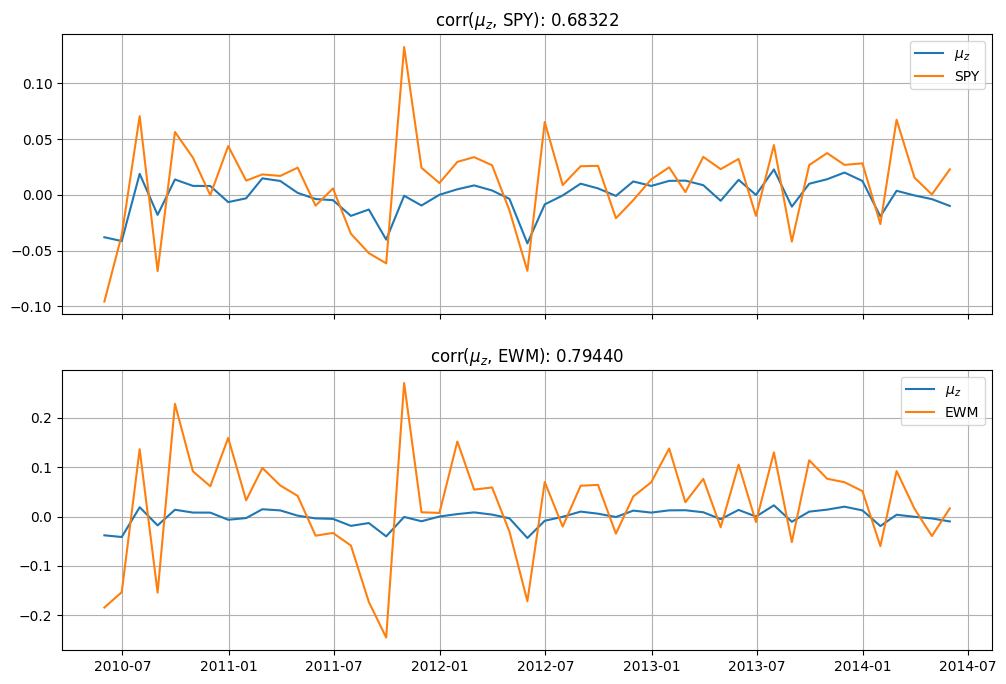

In [44]:
# Evaluate latent factors
mu, zs = get_latent_values(model, val_loader)
ewm_val = ewm[-len(val_loader):]
rm_val = rm[-len(val_loader):]
t = rm_val.index

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax1.plot(t, mu, label='$\mu_z$')
ax1.plot(t, rm_val, label='SPY')
ax1.set_title(f'corr($\mu_z$, SPY): {np.corrcoef(rm_val, mu.T)[0, 1]:.5f}')
ax1.legend()
ax1.grid()

ax2.plot(t, mu, label='$\mu_z$')
ax2.plot(t, ewm_val, label='EWM')
ax2.set_title(f'corr($\mu_z$, EWM): {np.corrcoef(ewm_val, mu.T)[0, 1]:.5f}')
ax2.legend()
ax2.grid()

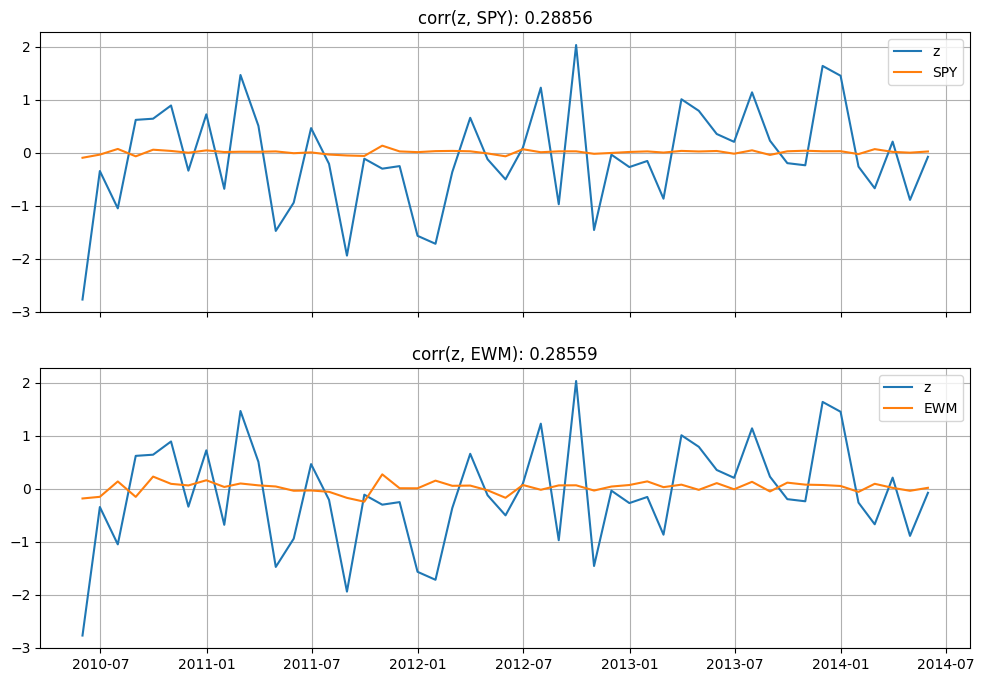

In [48]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax1.plot(t, zs, label='z')
ax1.plot(t, rm_val, label='SPY')
ax1.set_title(f'corr(z, SPY): {np.corrcoef(rm_val, zs.T)[0, 1]:.5f}')
ax1.legend()
ax1.grid()

ax2.plot(t, zs, label='z')
ax2.plot(t, ewm_val, label='EWM')
ax2.set_title(f'corr(z, EWM): {np.corrcoef(ewm_val, zs.T)[0, 1]:.5f}')
ax2.legend()
ax2.grid()

Best reconstructed stocks:
stock_85: beta*=0.7754 MSE =0.003706
stock_487: beta*=1.0441 MSE =0.011773
stock_61: beta*=0.6781 MSE =0.012068


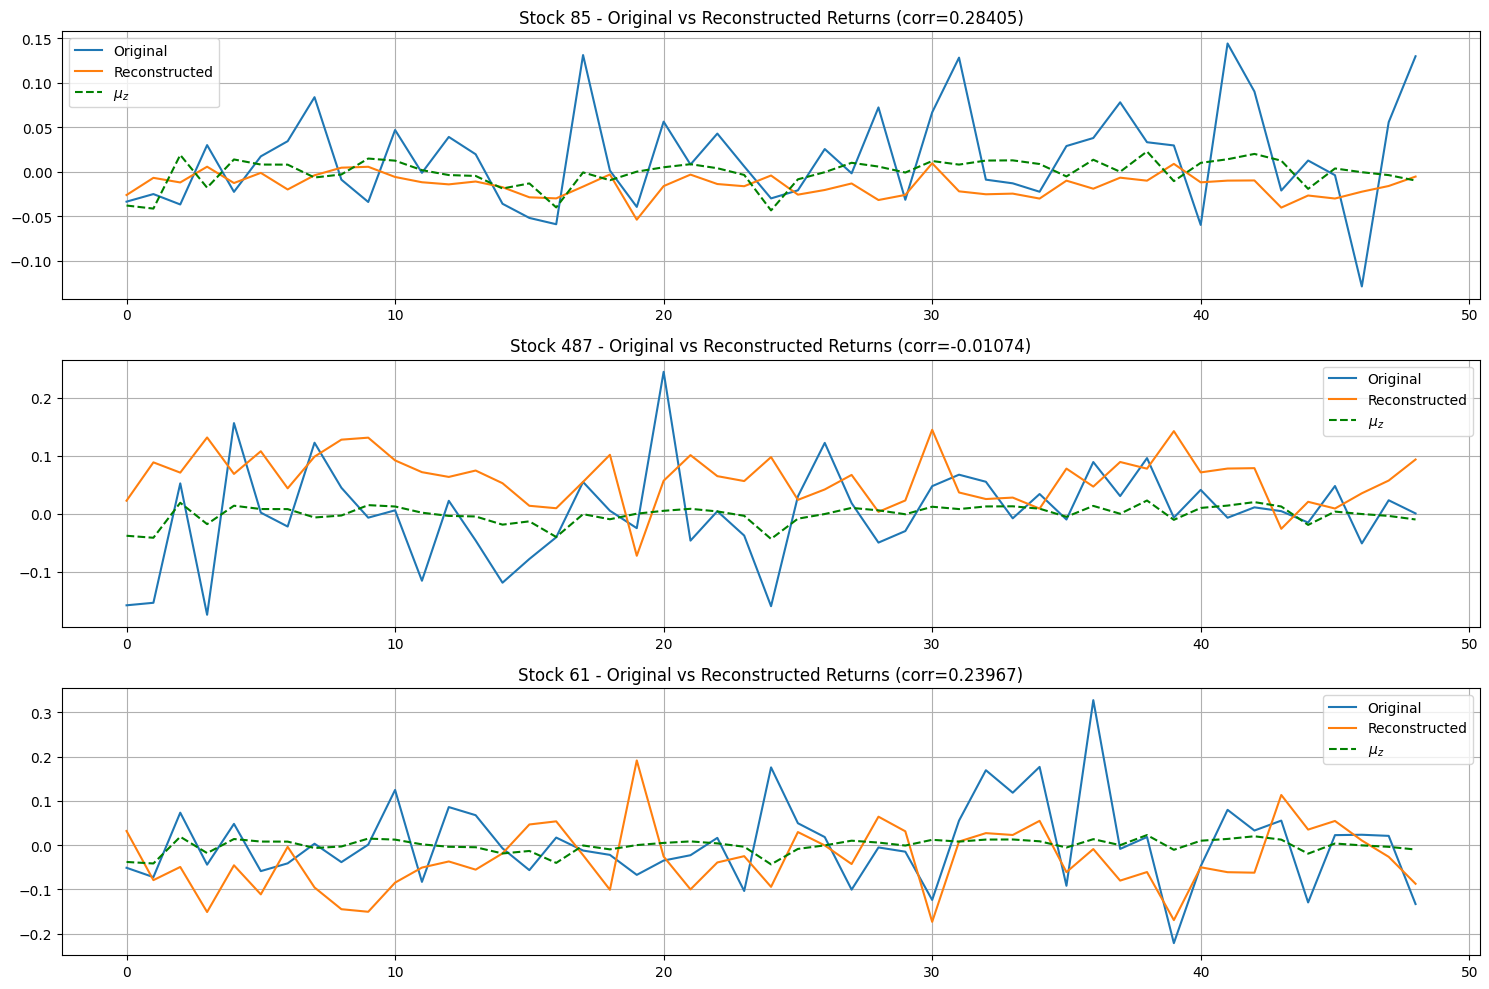


Worst reconstructed stocks:
stock_199: beta*=0.5810 MSE = 1.691981
stock_509: beta*=0.9793 MSE = 1.696432
stock_284: beta*=0.8080 MSE = 1.745191


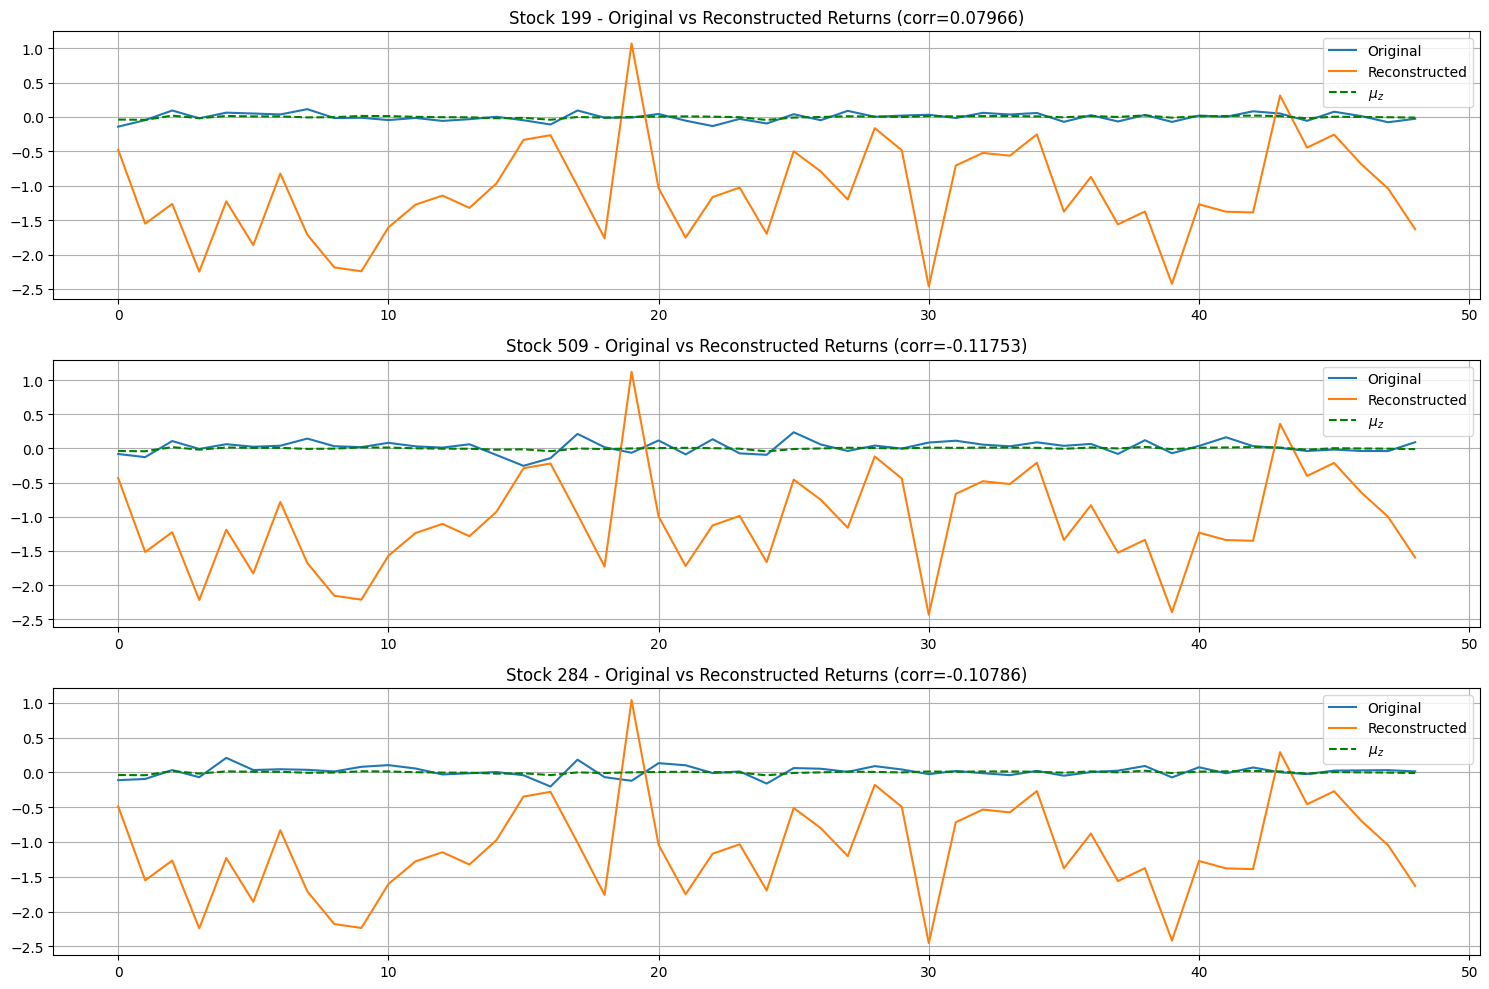

In [52]:
# Analyze reconstructions
mse_per_stock, orig, recon = calc_mse_per_stock(model, val_loader)

# Find best and worst reconstructed stocks
best_indices = np.argsort(mse_per_stock)[:3]  # 3 best
worst_indices = np.argsort(mse_per_stock)[-3:]  # 3 worst

print("Best reconstructed stocks:")
for idx in best_indices:
    print(f"stock_{idx}: beta*={beta[idx]:.4f} MSE ={mse_per_stock[idx]:.6f}")

plot_reconstruction(orig, recon, stock_indices=best_indices)

print("\nWorst reconstructed stocks:")
for idx in worst_indices:
    print(f"stock_{idx}: beta*={beta[idx]:.4f} MSE = {mse_per_stock[idx]:.6f}")

plot_reconstruction(orig, recon, stock_indices=worst_indices)

# TODOS:
- Check if the raw_data returns are anualised
- The genreated log_var is not good, the std turns out too big, use some other function like 0.5x^2 to extract std

# Questions
- EWM vs SPY log return graph, why different scale (EWM = 3 * SPY)?